<a href="https://colab.research.google.com/github/pachterlab/LSCHWCP_2023/blob/main/Notebooks/Supp_Fig_10/Supp_Fig_10abc/test_max_ham_code_palmdb2palmdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check detection of reverse translated RdRP sequences using a code that maximizes Hamming distances

In [1]:
# Download the customized transcripts to gene mapping
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_clustered_t2g.txt
# Download the RdRP amino acid sequences
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_rdrp_seqs.fa

palmdb = "palmdb_rdrp_seqs.fa"
virus_t2g = "palmdb_clustered_t2g.txt"

--2023-12-11 20:05:20--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_clustered_t2g.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4561689 (4.3M) [text/plain]
Saving to: ‘palmdb_clustered_t2g.txt’

palmdb_clustered_t2 100%[===================>]   4.35M  --.-KB/s    in 0.05s   

2023-12-11 20:05:21 (89.7 MB/s) - ‘palmdb_clustered_t2g.txt’ saved [4561689/4561689]

--2023-12-11 20:05:21--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/palmdb_rdrp_seqs.fa
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaitin

We will install an **unreleased version of kallisto which implements a different code for the translation of amino acid and nucleotide sequences** and subsequent alignment. This code maximizes the distances between amino acids that occur most frequently to increase the differences between reference sequences:

In [2]:
# Install kallisto from the max_ham_code branch
!git clone -q https://github.com/pachterlab/kallisto.git --branch max_ham_code
!cd kallisto && mkdir build && cd build && cmake .. && make

# Install bustools from source
!git clone -q https://github.com/BUStools/bustools.git
!cd bustools && mkdir build && cd build && cmake .. && make

# Define paths to kallisto and bustools binaries
kallisto = "/content/kallisto/build/src/kallisto"
bustools = "/content/bustools/build/src/bustools"

CMake Deprecation Warning at CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value or use a ...<max> suffix to tell
  CMake that the project does not need compatibility with older versions.


-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Performing Test COMPILER_SUPPORTS_CXX17
-- Performing Test COMPILER_SUPPORTS_CXX17 - Success
shared build
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_P

In [3]:
# Number of threads used for alignments
threads = 2

### Download PalmDB RdRP sequences reverse transalted to nucleotides as shown [here](https://github.com/pachterlab/LSCHWCP_2023/blob/main/Notebooks/Figure_3/Figure_3b/validate_palmdb2palmdb.ipynb):

In [4]:
!wget https://github.com/pachterlab/LSCHWCP_2023/raw/main/Notebooks/Figure_3/Figure_3b/palmdb_rdrp_seqs_nucleotides.fasta.zip
!unzip palmdb_rdrp_seqs_nucleotides.fasta.zip
palmdb_nn_fasta = "palmdb_rdrp_seqs_nucleotides.fasta"

--2023-12-11 20:09:50--  https://github.com/pachterlab/LSCHWCP_2023/raw/main/Notebooks/Figure_3/Figure_3b/palmdb_rdrp_seqs_nucleotides.fasta.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/Notebooks/Figure_3/Figure_3b/palmdb_rdrp_seqs_nucleotides.fasta.zip [following]
--2023-12-11 20:09:50--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/Notebooks/Figure_3/Figure_3b/palmdb_rdrp_seqs_nucleotides.fasta.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23125673 (22M) [application/zip]
Saving to: ‘palmdb_rdrp_seqs_nucleotides.fasta.zip’

palmdb

### Generate reference index from PalmDB amino acid sequences:

In [5]:
out_folder = "testing_cfc"
sample = "palmdb_vs_palmdb"

Since this branch of kallisto does not automatically set the D-list overhang to 3 when used in combination with `--aa`, we will specify it as 3 here:

In [9]:
# Generate virus reference index
virus_index = "index.idx"
!$kallisto index \
    --aa \
    --d-list-overhang 3 \
    -t $threads \
    -i $virus_index \
    $palmdb


[build] loading fasta file palmdb_rdrp_seqs.fa
[build] k-mer length: 31
KmerStream::KmerStream(): Start computing k-mer cardinality estimations (1/2)
KmerStream::KmerStream(): Start computing k-mer cardinality estimations (1/2)
KmerStream::KmerStream(): Finished
CompactedDBG::build(): Estimated number of k-mers occurring at least once: 38022726
CompactedDBG::build(): Estimated number of minimizer occurring at least once: 8020656
CompactedDBG::filter(): Processed 87630084 k-mers in 296561 reads
CompactedDBG::filter(): Found 37937748 unique k-mers
CompactedDBG::filter(): Number of blocks in Bloom filter is 259922
CompactedDBG::construct(): Extract approximate unitigs (1/2)
CompactedDBG::construct(): Extract approximate unitigs (2/2)
CompactedDBG::construct(): Closed all input files

CompactedDBG::construct(): Splitting unitigs (1/2)

CompactedDBG::construct(): Splitting unitigs (2/2)
CompactedDBG::construct(): Before split: 1955467 unitigs
CompactedDBG::construct(): After split (1/1): 1

### Align using comma-free code:

In [10]:
!mkdir -p $out_folder

!$kallisto bus \
        -i $virus_index \
        -o $out_folder/$sample \
        --aa \
        -t $threads  \
        -x bulk \
        $palmdb_nn_fasta

!$bustools sort -o $out_folder/$sample/output_sorted.bus $out_folder/$sample/output.bus

!$bustools count \
    --genecounts \
    --cm -m \
    -o $out_folder/$sample/bustools_count/ \
    -g $virus_t2g \
    -e $out_folder/$sample/matrix.ec \
    -t $out_folder/$sample/transcripts.txt \
    $out_folder/$sample/output_sorted.bus


[index] k-mer length: 31
[index] number of targets: 296,561
[index] number of k-mers: 37,971,144
[quant] running in single-end mode
[quant] will process file 1: palmdb_rdrp_seqs_nucleotides.fasta
[quant] finding pseudoalignments for all files ... done
[quant] processed 296,561 reads, 288,226 reads pseudoaligned

 all fits in buffer
Read in 288226 BUS records
reading time 0.002467s
sorting time 0.025842s
writing time 0.013976s


### Load and plot results:

In [11]:
!pip install -q kb_python
import kb_python.utils as kb_utils
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 84.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 90.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 77.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.6 MB/s eta 0:00:00


In [12]:
# Load count matrix
# Filepath to counts
X = f"{out_folder}/{sample}/bustools_count/output.mtx"
# Filepath to barcode metadata
var_path = f"{out_folder}/{sample}/bustools_count/output.genes.txt"
# Filepath to gene metadata
obs_path = f"{out_folder}/{sample}/bustools_count/output.barcodes.txt"

# Create AnnData object
adata = kb_utils.import_matrix_as_anndata(X, obs_path, var_path)
adata

AnnData object with n_obs × n_vars = 1 × 99228

In [13]:
# Load virus ID to taxonomy mapping
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/ID_to_taxonomy_mapping.csv
rep_id_df = pd.read_csv("ID_to_taxonomy_mapping.csv")
rep_id_df

--2023-12-11 20:18:37--  https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/ID_to_taxonomy_mapping.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19705497 (19M) [text/plain]
Saving to: ‘ID_to_taxonomy_mapping.csv’

ID_to_taxonomy_mapp 100%[===================>]  18.79M  --.-KB/s    in 0.09s   

2023-12-11 20:18:38 (202 MB/s) - ‘ID_to_taxonomy_mapping.csv’ saved [19705497/19705497]



,ID,rep_ID,phylum,class,order,family,genus,species,strandedness
0,u1,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
1,u10066,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
2,u10121,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
3,u10124,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
4,u102609,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...,+ssRNA
...,...,...,...,...,...,...,...,...,...
296556,u296608,u296608,.,.,.,.,.,.,unknown
296557,u296609,u296609,.,.,.,.,.,.,unknown
296558,u296613,u296613,.,.,.,.,.,.,unknown
296559,u296616,u296616,.,.,.,.,.,.,unknown


Record expected and observed counts for each virus ID (since the virus IDs are grouped based on taxonomy like transcripts of the same gene, we expect different numbers of counts for each representative virus ID):

In [14]:
%%time
counts = []
expected_counts = []
for virus_id in adata.var.index:
    counts.append(adata[:, adata.var.index==virus_id].X.sum())
    expected_counts.append(len(rep_id_df[rep_id_df["rep_ID"]==virus_id]))

CPU times: user 49min 36s, sys: 5.33 s, total: 49min 42s
Wall time: 50min 3s


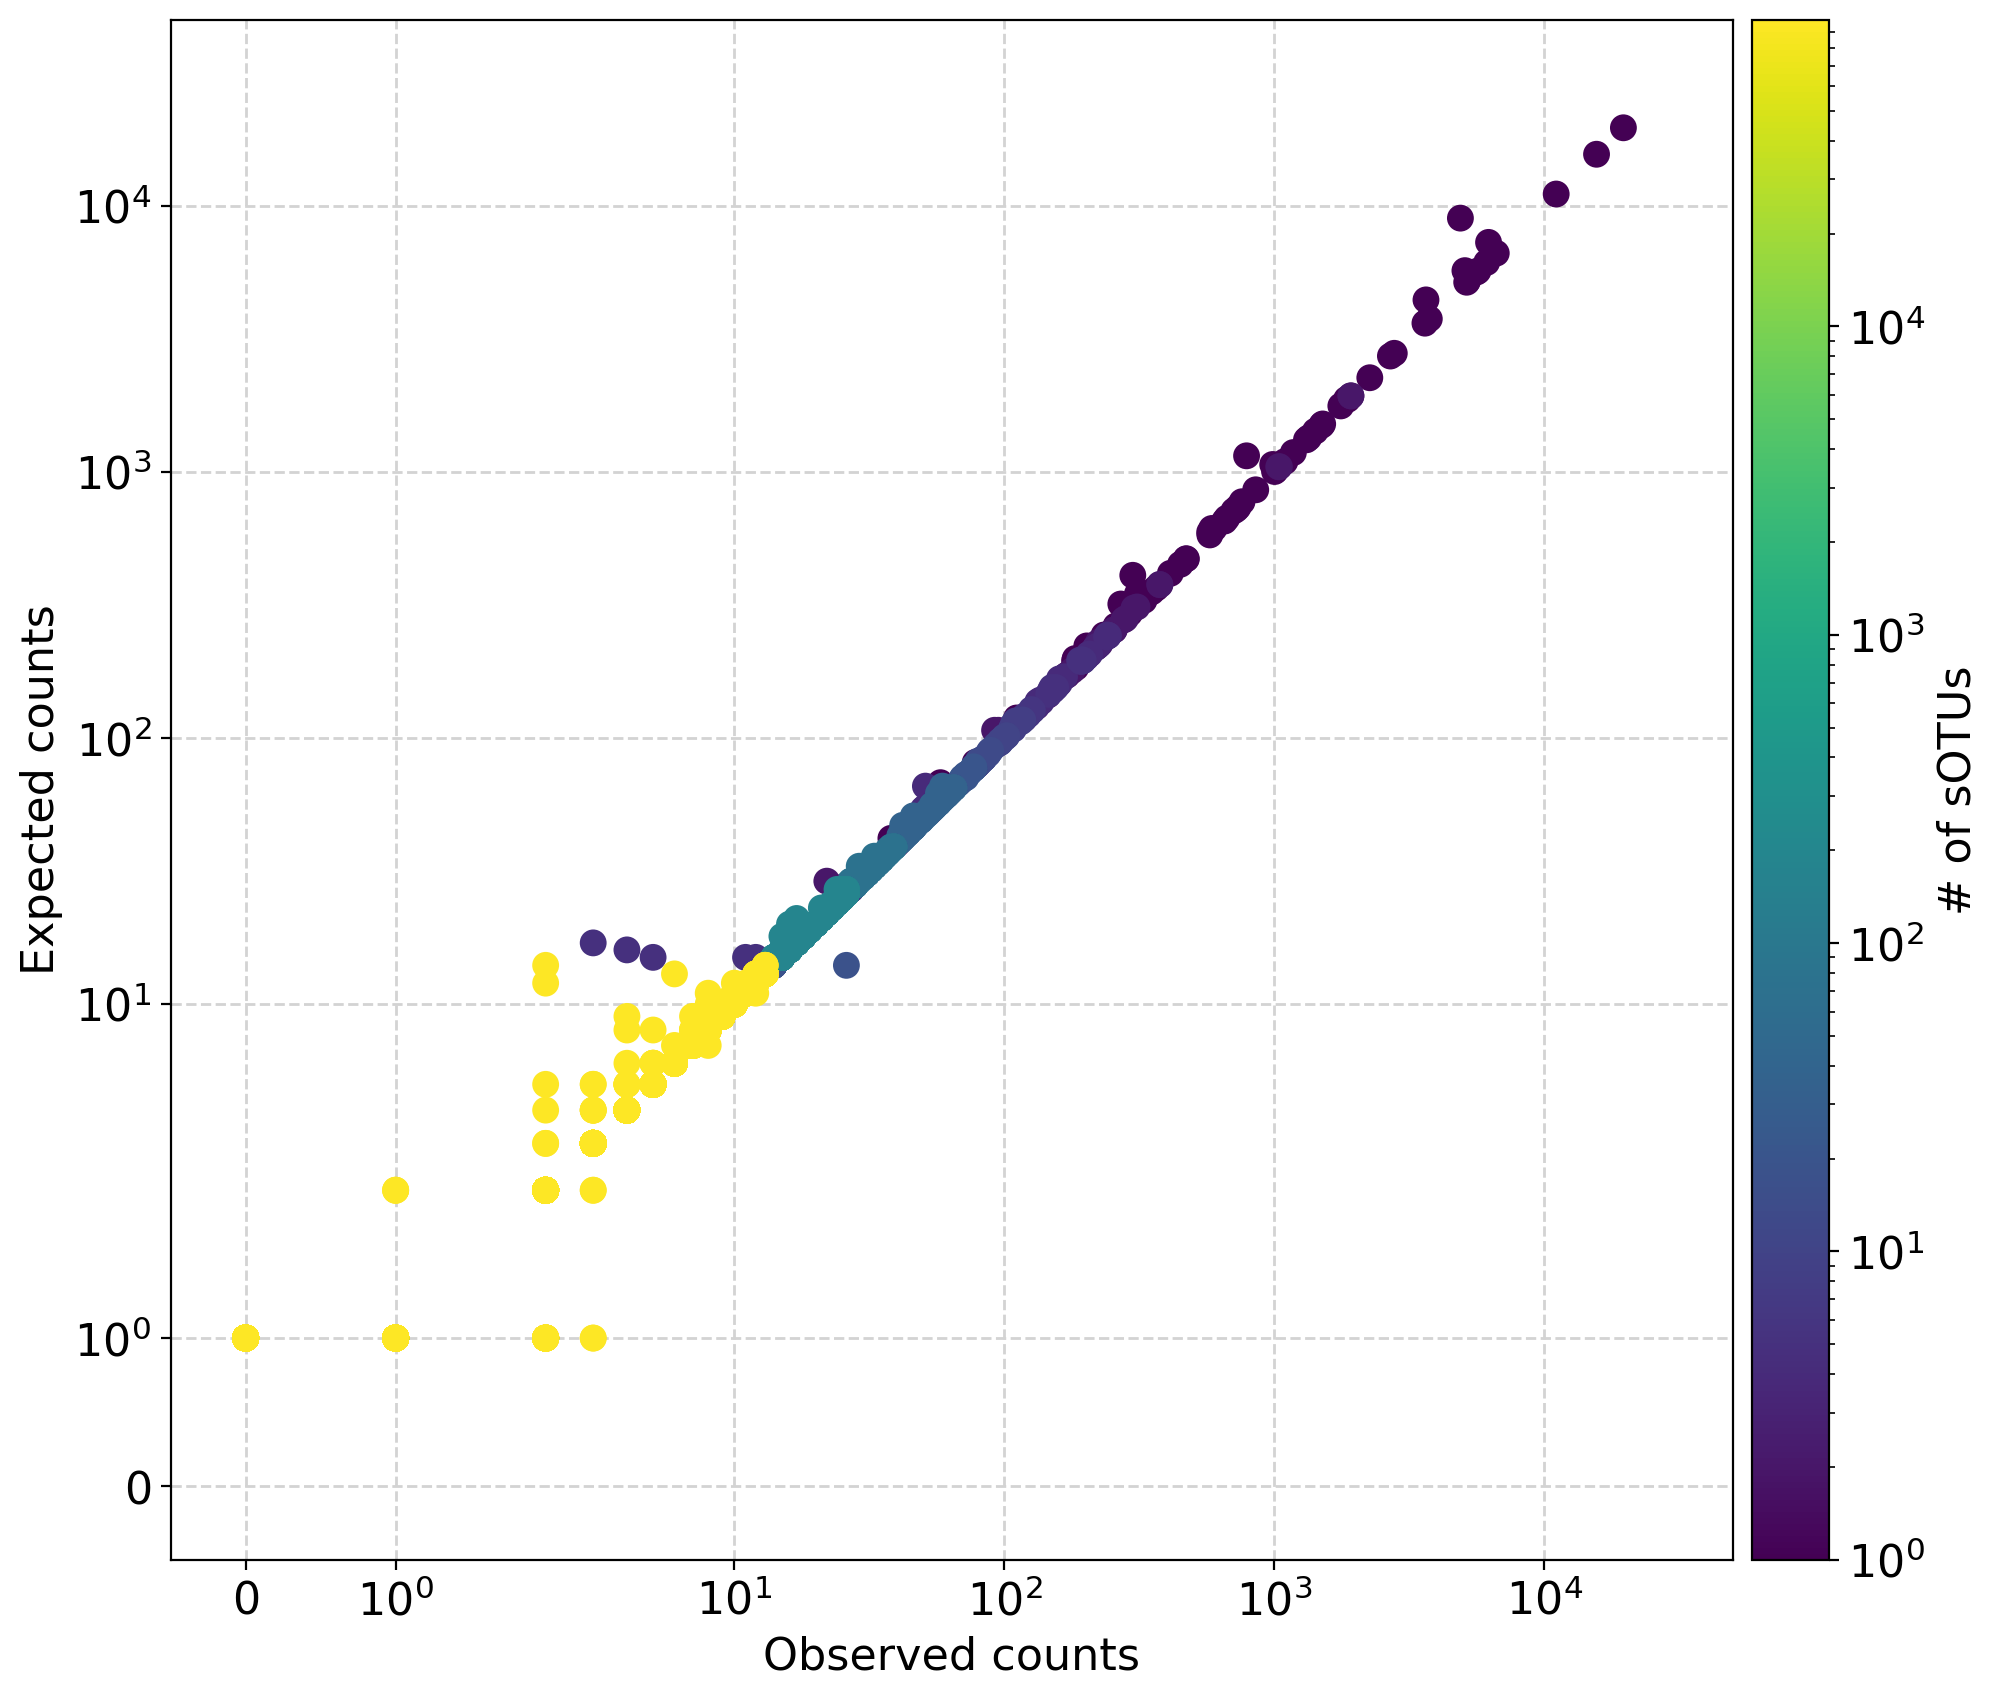

In [15]:
fig, ax = plt.subplots(figsize=(12,10))
fontsize = 16

x = np.array(counts)
y = np.array(expected_counts)

# Histogram data to show point density
bins = [1500, 1500]
hh, locx, locy = np.histogram2d(x, y, bins=bins)
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

scatter = ax.scatter(x2, y2, c=z2, cmap="viridis", norm=matplotlib.colors.LogNorm(), s=75)

# Add colorbar
cbar = fig.colorbar(scatter, ax=ax, pad=0.01)
cbar.ax.tick_params(axis="both", labelsize=fontsize)
cbar.ax.set_ylabel(f"# of sOTUs", fontsize=fontsize)

ax.set_ylim(bottom=-0.5, top=50000)
ax.set_xlim(left=-0.5, right=50000)

ax.set_yscale("symlog")
ax.set_xscale("symlog")

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)

ax.tick_params(axis="both", labelsize=fontsize)
ax.set_ylabel("Expected counts", fontsize=fontsize)
ax.set_xlabel("Observed counts", fontsize=fontsize)

plt.savefig(f"expected_vs_observed_vir_counts_{sample}.png", dpi=300, bbox_inches="tight")

fig.show()

Pearson and Spearman correlations between expected and observed counts:

In [22]:
from scipy.stats import pearsonr,spearmanr

In [21]:
pearsonr(np.array(counts), np.array(expected_counts))

PearsonRResult(statistic=0.992817351791723, pvalue=0.0)

In [23]:
spearmanr(np.array(counts), np.array(expected_counts))

SignificanceResult(statistic=0.7791531684556423, pvalue=0.0)